# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [ ]:
%%capture 
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [ ]:
%%capture 
!pip install git+https://github.com/huggingface/transformers

In [ ]:
%%capture 
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [ ]:
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
#import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import pickle #if you want to save layouts
import os
import io

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig # pip install tranformers
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

In [ ]:
%matplotlib inline

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/SOCI Computational Content Analysis/data'

In [ ]:
torch.__version__

'1.10.0+cu111'

# ConvoKit
As we alluded to in Week 6 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [ ]:
%%capture 
!pip install convokit

In [ ]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [ ]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

In [ ]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [ ]:
# This is a Reddit thread
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.Cornell',
 'gilded': 0,
 'gildings': None,
 'num_comments': 2,
 'stickied': False,
 'subreddit': 'Cornell',
 'timestamp': 1528070645,
 'title': 'Has anyone transferred into Cornell their second semester of freshman year?'}

In [ ]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'author_flair_text': '2019',
 'gilded': 0,
 'gildings': None,
 'permalink': '',
 'retrieved_on': 1486128868,
 'score': 1,
 'stickied': False,
 'subreddit': 'Cornell',
 'top_level_comment': 'dcjrn9s'}

In [ ]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f967b525fd0>, 'id': 'blahdeehbla'})

"I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).\n\nI want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?"

In [ ]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
n, m = 0, 0
for i, utt in enumerate(corpus.iter_utterances()):
    if n <= i <= m:
        print(utt.text)

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
print(spkr_convos[:2])

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'Transfer Application', 'num_comments': 4, 'domain': 'self.Cornell', 'timestamp': 1529037978, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f967b525fd0>, 'id': '8r8bl2'}), Conversation({'obj_type': 'conversation', 'meta': {'title': 'FIFA WORLD CUP!', 'num_comments': 25, 'domain': 'self.Cornell', 'timestamp': 1529628946, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': 'Bagel Studies'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f967b525fd0>, 'id': '8sx6nz'})]


For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [ ]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

I'm looking for some classes that are either fun or interesting to take. Both fa

    What kind of subject are you interested in? I took intro astronomy with Prof Llo

    social psych with gilovich in the spring, but take it s-u for sure

        This class is pretty hard if you're not familiar with psych terminology or socio

            I'm a freshman in both social psych and soc 101. soc 101 is such a bore and does

                It's being taken over by Harry Segal, who is just as awesome as Maas but without

                    Harry segal is still around? wow. took adult psychopathology with that guy back 

    I already posted a [thread asking this same question](http://www.reddit.com/r/Co

    ILRIC 6020: Corporate Social Responsibility.  The professor gives out the A+ gra

    I know you are looking more for academic courses, but you should also explore Co

    Desire (FGSS 2760) or Decadence (cant find the course number right now) with Ell

    ASTRO 1102 with Steve Squyre

There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

In [ ]:
#Transcripts for tennis singles post-match press conferences for major tournaments between 2007 to 2015 
#(6,467 post-match press conferences).

corpus = Corpus(download('tennis-corpus'))

In [ ]:
corpus.print_summary_stats()

Number of Speakers: 359
Number of Utterances: 163948
Number of Conversations: 81974


In [ ]:
#This is a random press conference
corpus.random_conversation().meta

{'match_id': 5153,
 'opponent': 'Stephanie Dubois',
 'player_ranking': 104,
 'result': 1,
 'stage': '1st Round',
 'tournament': 'ROGERS CUP WOMEN',
 'tournament_type': 'Premier'}

In [ ]:
# This is a press conference intervention: question or answer?
corpus.random_utterance().meta

{'is_answer': True, 'is_question': False, 'pair_idx': '5637_9'}

In [ ]:
# Speaker metadata corresponds to the gender of the tennis player
corpus.random_speaker().meta


{'gender': 'M'}

In [ ]:
#Speaker do have an 'id' which is their name, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {'gender': 'M'}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f4e4a7b9950>, 'id': 'Erik Chvojka'})

In [ ]:
n, m = 0, 0
for i, utt in enumerate(corpus.iter_utterances()):
    if n <= i <= m:
        print(utt.text)

I think this is your biggest success right now, first Grand Slam, third round.


In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
print(spkr_convos[:2])

[Conversation({'obj_type': 'conversation', 'meta': {'match_id': 1681, 'opponent': nan, 'result': 1, 'stage': '2nd Round', 'tournament': 'U.S. OPEN', 'tournament_type': 'Grand Slam', 'player_ranking': 126}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f4e4a7b9950>, 'id': '1681_0.q'}), Conversation({'obj_type': 'conversation', 'meta': {'match_id': 1681, 'opponent': nan, 'result': 1, 'stage': '2nd Round', 'tournament': 'U.S. OPEN', 'tournament_type': 'Grand Slam', 'player_ranking': 126}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f4e4a7b9950>, 'id': '1681_1.q'})]


In [ ]:
# We can check if the Corpus contains an object with a specified ID
corpus.has_speaker('Roger Federer')

True

In [ ]:
corpus.has_speaker('Serena Williams')

True

In [ ]:
# We can fetch individual objects by ID
corpus.get_speaker('Roger Federer')

Speaker({'obj_type': 'speaker', 'meta': {'gender': 'M'}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f4e4a7b9950>, 'id': 'Roger Federer'})

In [ ]:
# We can even generate dataframes of each component
corpus.get_utterances_dataframe().head()

,timestamp,text,speaker,reply_to,conversation_id,meta.is_answer,meta.is_question,meta.pair_idx,vectors
id,,,,,,,,,
1681_0.q,2008-08-28,I think this is your biggest success right now...,REPORTER,None,1681_0.q,False,True,1681_0,[]
1681_0.a,2008-08-28,Yeah.,Kei Nishikori,1681_0.q,1681_0.q,True,False,1681_0,[]
1681_1.q,2008-08-28,How would you describe it? Is it fantastic for...,REPORTER,None,1681_1.q,False,True,1681_1,[]
1681_1.a,2008-08-28,"Yeah, I'm pretty happy, but it was -- I wasn't...",Kei Nishikori,1681_1.q,1681_1.q,True,False,1681_1,[]
1681_2.q,2008-08-28,Do you know why he has retired?,REPORTER,None,1681_2.q,False,True,1681_2,[]


In [ ]:
#To check the conversation structure
convo.print_conversation_structure()

REPORTER
    Andy Murray


In [ ]:
from convokit import FightingWords

In [ ]:
fw = FightingWords()

Initializing default CountVectorizer with ngram_range (1, 3)... Done.


In [ ]:
utt_list = []
for i, utt in enumerate(corpus.iter_utterances()):
    if i < 12000:
        utt_list.append(utt)
ncorpus = Corpus(utterances=utt_list)

In [ ]:
utt = ncorpus.random_utterance()
utt.speaker.meta

{}

In [ ]:
'gender' in utt.speaker.meta.keys() and utt.speaker.meta['gender'] == 'M' # checkea si tiene género en la metadata y si lo tiene chequea que sea M

False

In [ ]:
fw.fit(ncorpus,
       class1_func=lambda utt: 'gender' in utt.speaker.meta.keys() and utt.speaker.meta['gender'] == 'M',
       class2_func=lambda utt: 'gender' in utt.speaker.meta.keys() and utt.speaker.meta['gender'] == 'F'
       )

class1_func returned 3257 valid corpus components. class2_func returned 2743 valid corpus components.
Vocab size is 8955
Comparing language...
ngram zscores computed.


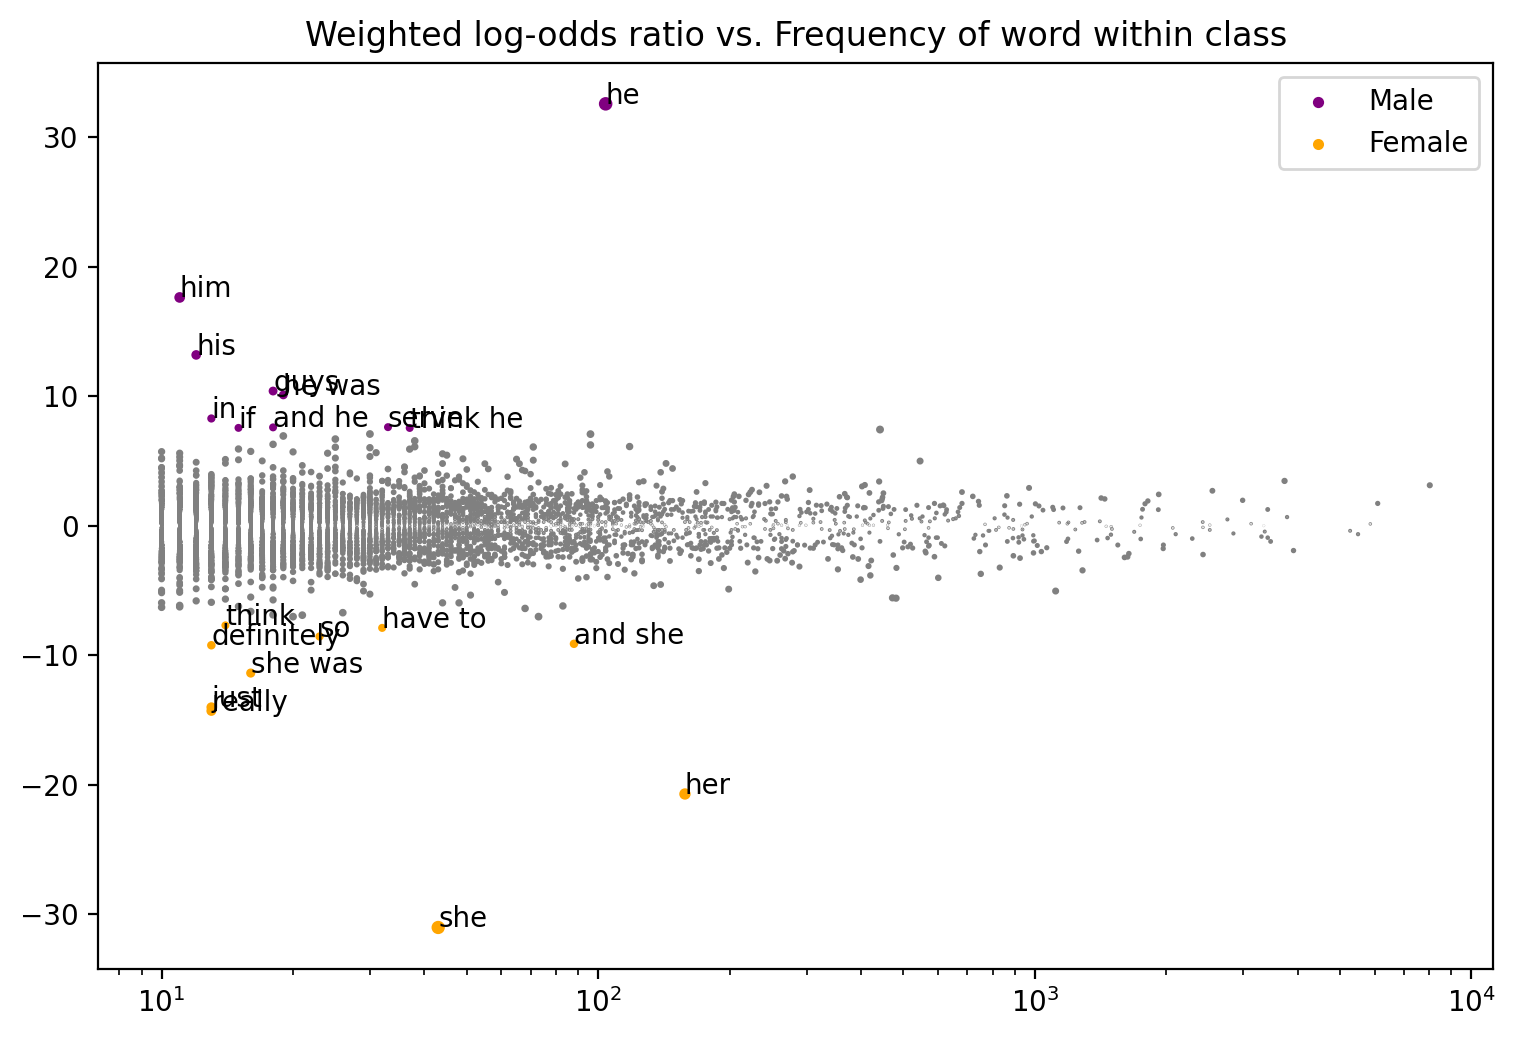

,z-score,class
ngram,,
she,-31.030959,Female
her,-20.720147,Female
really,-14.302293,Female
just,-14.020488,Female
she was,-11.378994,Female
...,...,...
he was,10.104741,Male
guys,10.404965,Male
his,13.195664,Male


In [ ]:
fw.summarize(ncorpus, plot=True, class1_name='Male', class2_name='Female')

Trying TRANSFORMERS with reddit dataset

Using lambda functions, we define two groups of utterances between which we would like to find differences in speech:

In [ ]:
utt = corpus.random_utterance()
utt.meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'permalink': '/r/explainlikeimfive/comments/9f5ngp/eli5_why_does_the_back_usually_hurt_after/e5uuvmk/',
 'retrieved_on': 1538981442,
 'score': 5,
 'stickied': False,
 'subreddit': 'explainlikeimfive',
 'top_level_comment': 'e5tzqow'}

In [ ]:
fw.fit(corpus, class1_func = lambda utt: utt.meta['subreddit'] == 'Christianity',
       class2_func = lambda utt: utt.meta['subreddit'] == 'atheism')

class1_func returned 2659 valid corpus components. class2_func returned 2736 valid corpus components.
Vocab size is 5034
Comparing language...
ngram zscores computed.



We can see a summary of what it has learned using the ``summarize()`` method.

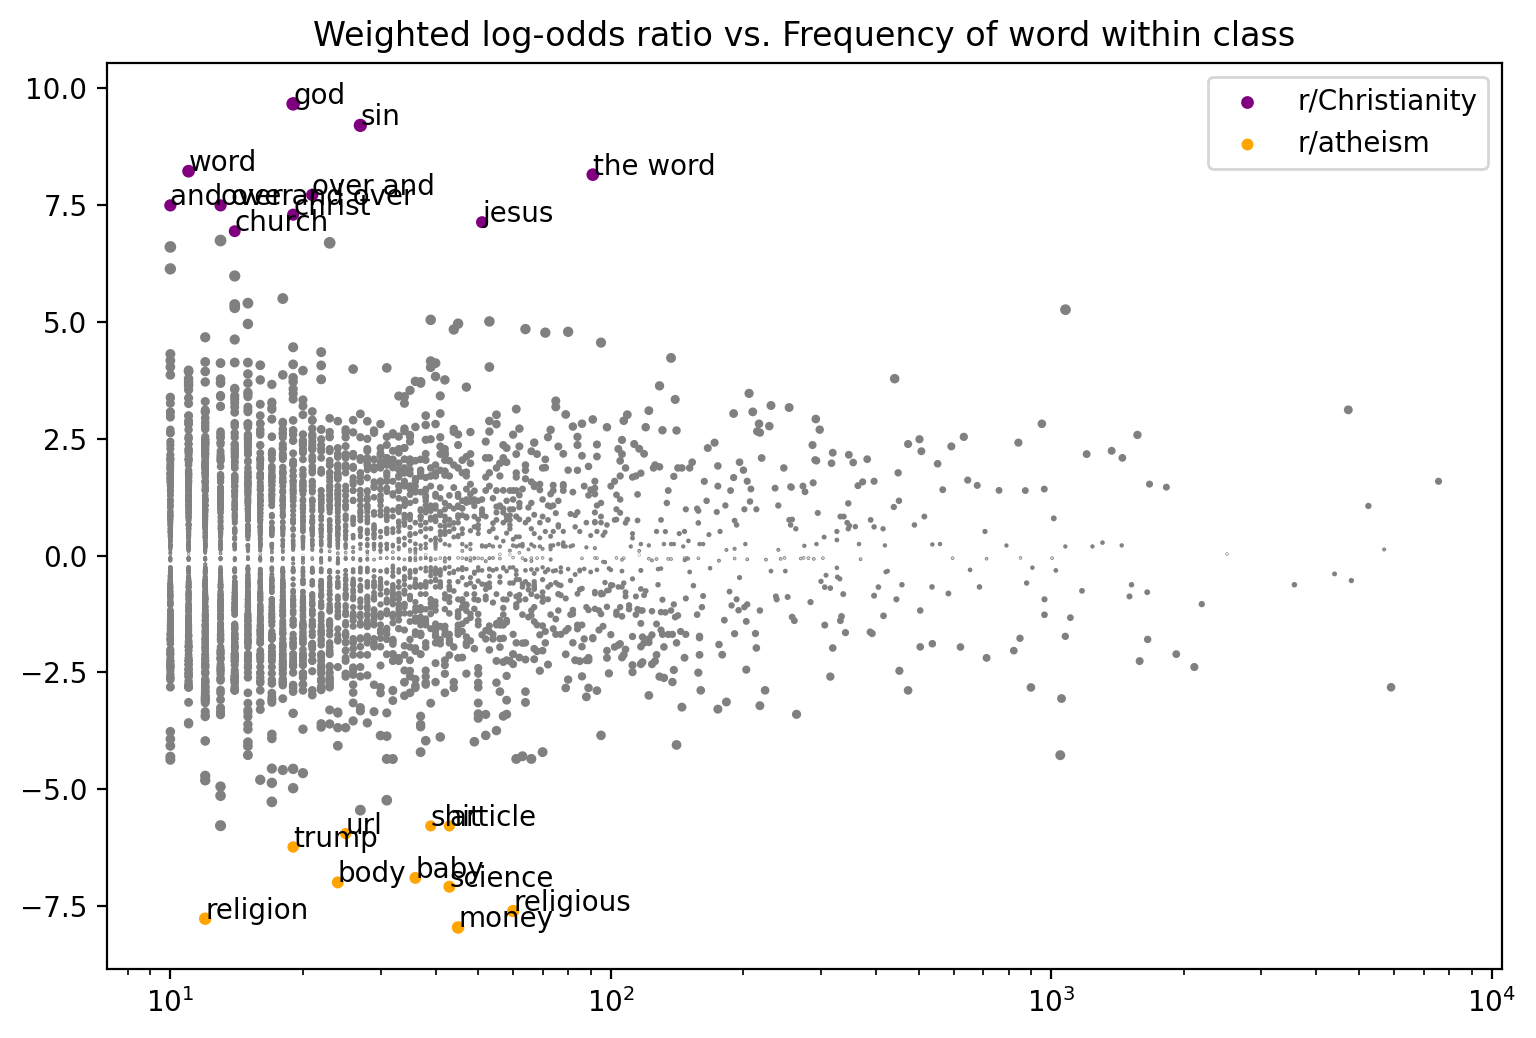

,z-score,class
ngram,,
money,-7.957425,r/atheism
religion,-7.769434,r/atheism
religious,-7.605858,r/atheism
science,-7.084885,r/atheism
body,-6.993762,r/atheism
...,...,...
over and,7.718249,r/Christianity
the word,8.149449,r/Christianity
word,8.223430,r/Christianity


In [ ]:
fw.summarize(corpus, plot=True, class1_name='r/Christianity', class2_name='r/atheism')

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = f'{data_path}/Bayesian-echo/results/{example_name}/'
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [ ]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [ ]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

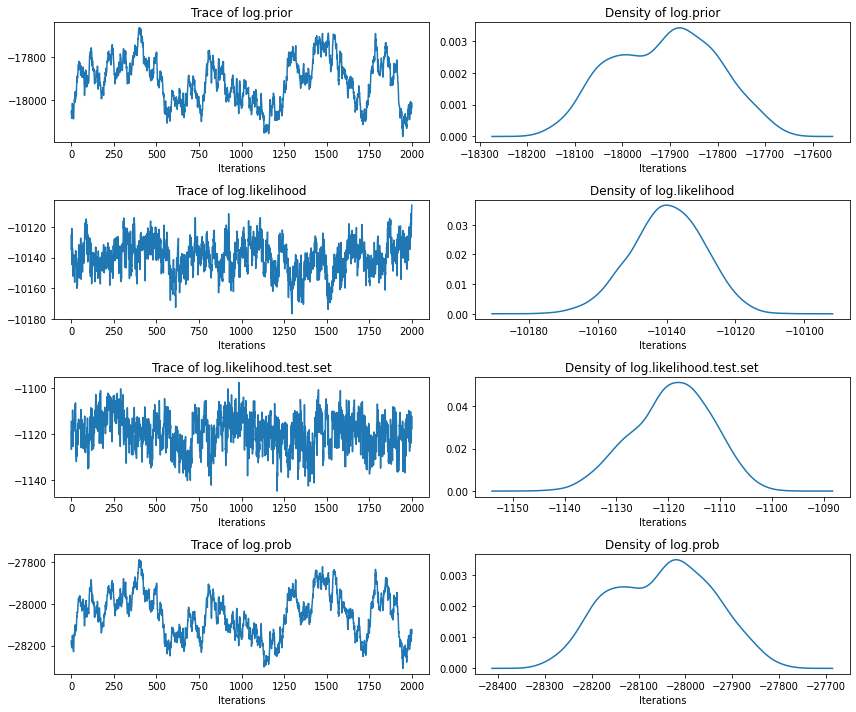

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
id_person

{0: 'Juror 8',
 1: 'Juror 3',
 2: 'Juror 10',
 3: 'Foreman',
 4: 'Juror 7',
 5: 'Juror 4',
 6: 'Juror 11',
 7: 'Juror 12',
 8: 'Juror 6',
 9: 'Juror 2',
 10: 'Juror 9',
 11: 'Juror 5'}

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ = df_.rename(index = id_person)
    df_ = df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked, A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked, A)

In [ ]:
df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


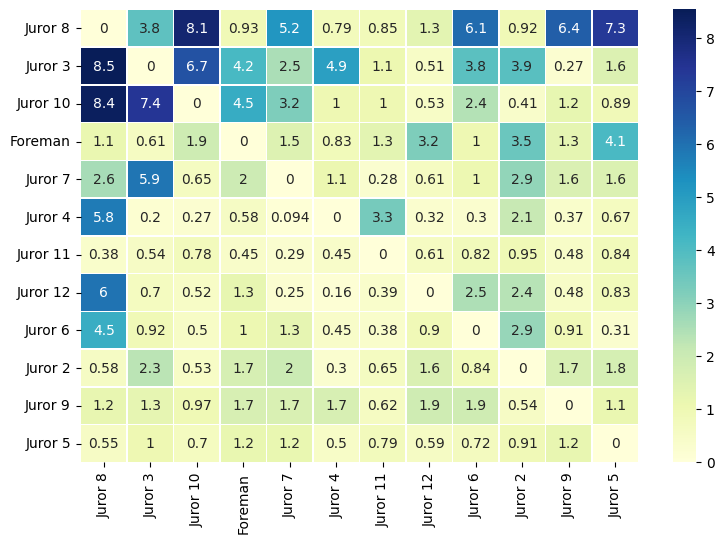

In [ ]:
f, ax = plt.subplots(figsize=(9, 6), dpi=100)
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


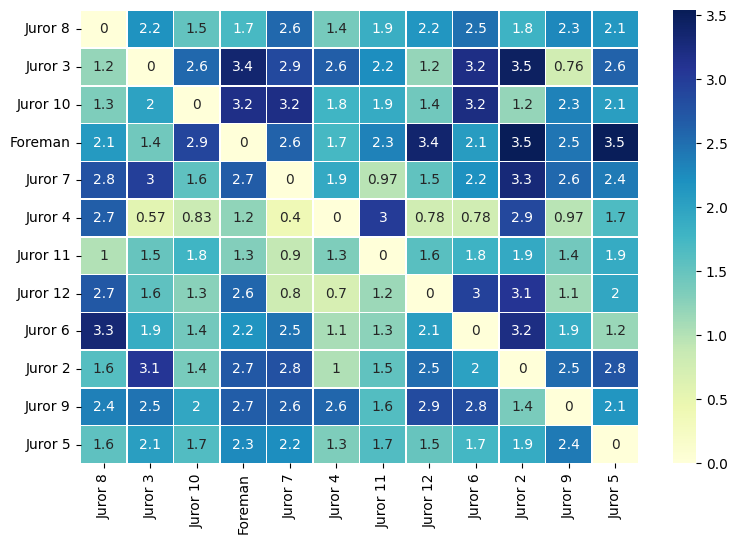

In [ ]:
f, ax = plt.subplots(figsize=(9, 6), dpi=100)
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

In [ ]:
values = list(sent.values) + list(recieved.values)
speakers = list(person_id.keys())*2
enunciators = ['sent']*len(list(sent.values)) + ['recieved']*len(list(recieved.values))

df = pd.DataFrame({'speaker': speakers,
                    'value': values,
                    'enunciator': enunciators})
df

,speaker,value,enunciator
0,Juror 8,41.630452,sent
1,Juror 3,37.908255,sent
2,Juror 10,31.115055,sent
3,Foreman,20.594713,sent
4,Juror 7,20.270128,sent
5,Juror 4,14.057715,sent
6,Juror 11,6.603260,sent
7,Juror 12,15.421062,sent
8,Juror 6,14.101755,sent
9,Juror 2,14.010204,sent


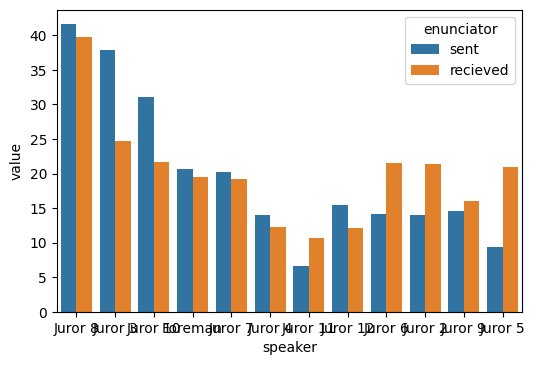

In [ ]:
plt.figure(dpi=100)
ax = seaborn.barplot(x="speaker", y="value", hue='enunciator', data=df)

In [ ]:
person_id.keys()
sent.values
#recieved


array([41.63045168, 37.90825533, 31.11505501, 20.59471335, 20.27012834,
       14.05771535,  6.60325973, 15.42106187, 14.10175518, 14.01020424,
       14.61529786,  9.34586814])

		Total linguistic influence sent/received 


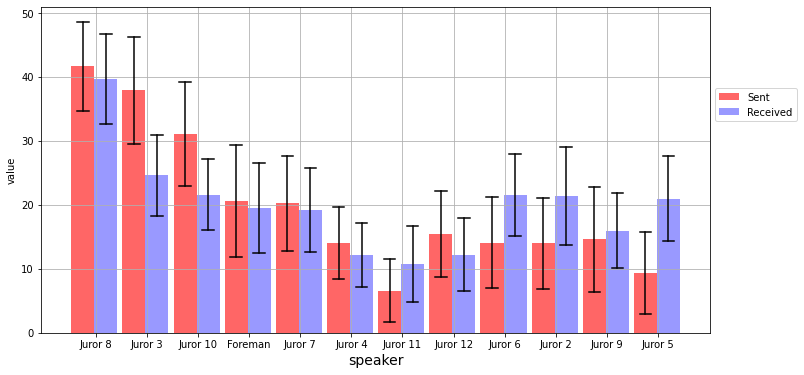

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


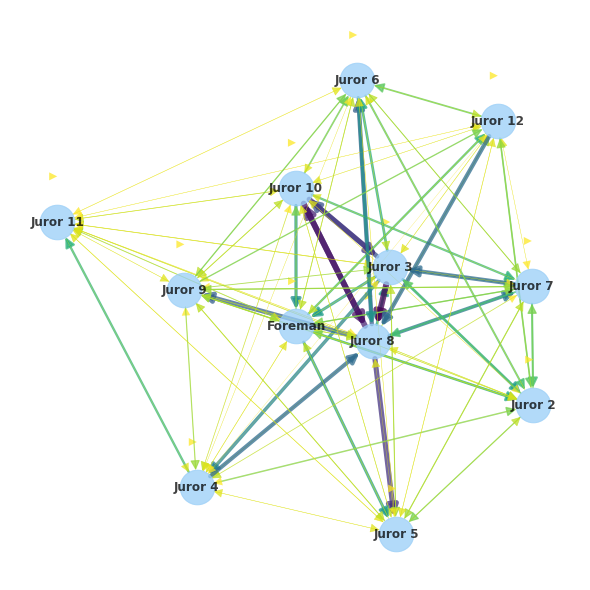

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


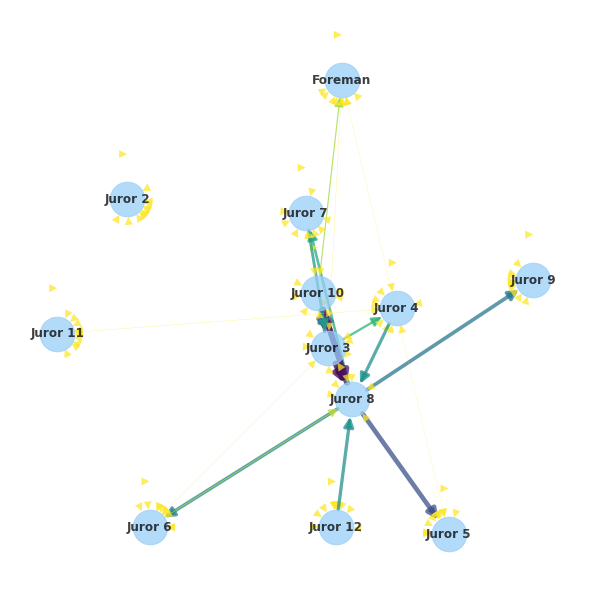

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


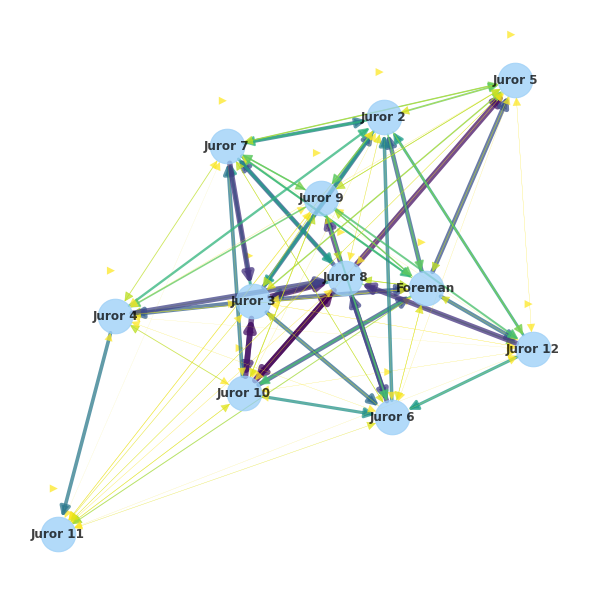

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript

,name,tokens,start,end
0,Trump,"[akkc, kcgs, blii, echd, ijdh, dscg, dhdf, ski...",0.880354,1.817431
1,Trump,"[djsc, lblf, fgff, kcss, cjjf, afba, kgjd, ghl...",2.909385,3.590462
2,Bush,"[gebf, ggib, jabh, hhdk, sshg, chbf, cicc, fch...",4.612774,5.371177
3,Bush,"[sehs, bfba, fsle, ibdc, cehl, gahb, dfag, jsi...",6.762208,7.767210
4,Roosevelt,"[flgb, higg, ljea, jdki, djak, gkbb, eeba, kjs...",8.329452,9.584323
...,...,...,...,...
285,Clinton,"[bbck, ljhe, fkfa, sdsf, cdde, sbsd, iles, bjl...",570.235573,571.969679
286,Reagan,"[jede, blfa, jhfg, bcsh, lkss, gsae, gfil, sal...",572.762334,573.094914
287,Nixon,"[kehc, asgi, hcaj, fdcc, sbih, lgjf, llbk, hls...",574.533157,575.929007
288,Reagan,"[kidh, kghs, fbfs, slgd, kccg, ided, lldk, kda...",576.485323,577.142649


Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [ ]:
#A collection of all the conversations that occurred over 10 seasons of Friends, a popular 
#American TV sitcom that ran in the 1990s.

corpus = Corpus(download('friends-corpus'))

In [ ]:
corpus.print_summary_stats()

Number of Speakers: 700
Number of Utterances: 67373
Number of Conversations: 3107


In [ ]:
#This is a random conversation within a particular scene. 
corpus.random_conversation().meta

{'episode': 'e21', 'scene': 'c13', 'season': 's04'}

In [ ]:
full_df = corpus.get_utterances_dataframe()
full_df

,timestamp,text,speaker,reply_to,conversation_id,meta.tokens,meta.character_entities,meta.emotion,meta.caption,meta.transcript_with_note,meta.tokens_with_note,vectors
id,,,,,,,,,,,,
s01_e01_c01_u001,None,There's nothing to tell! He's just some guy I ...,Monica Geller,None,s01_e01_c01_u001,"[[There, 's, nothing, to, tell, !], [He, 's, j...","[[], [[0, 1, Paul the Wine Guy], [4, 5, Paul t...",None,None,None,None,[]
s01_e01_c01_u002,None,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,s01_e01_c01_u001,"[[C'mon, ,, you, 're, going, out, with, the, g...","[[[2, 3, Monica Geller], [8, 9, Paul the Wine ...",None,None,None,None,[]
s01_e01_c01_u003,None,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,s01_e01_c01_u001,"[[All, right, Joey, ,, be, nice, .], [So, does...","[[[2, 3, Joey Tribbiani]], [[2, 3, Paul the Wi...",None,None,None,None,[]
s01_e01_c01_u004,None,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,s01_e01_c01_u001,"[[Wait, ,, does, he, eat, chalk, ?]]","[[[3, 4, Paul the Wine Guy]]]",None,None,None,None,[]
s01_e01_c01_u005,None,,TRANSCRIPT_NOTE,s01_e01_c01_u004,s01_e01_c01_u001,[],[],None,None,"(They all stare, bemused.)","[[(, They, all, stare, ,, bemused, ., )]]",[]
...,...,...,...,...,...,...,...,...,...,...,...,...
s10_e18_c11_u017,None,"Oh, it's gonna be okay.",Chandler Bing,s10_e18_c11_u016,s10_e18_c11_u000,"[[Oh, ,, it, 's, gon, na, be, okay, .]]",None,None,None,"Oh, it's gonna be okay. (Chandler hugs her. Mo...","[[Oh, ,, it, 's, gon, na, be, okay, .], [(, Ch...",[]
s10_e18_c11_u018,None,Do you guys have to go to the new house right ...,Rachel Green,s10_e18_c11_u017,s10_e18_c11_u000,"[[Do, you, guys, have, to, go, to, the, new, h...",None,None,None,(crying) Do you guys have to go to the new hou...,"[[(, crying, ), Do, you, guys, have, to, go, t...",[]
s10_e18_c11_u019,None,We got some time.,Monica Geller,s10_e18_c11_u018,s10_e18_c11_u000,"[[We, got, some, time, .]]",None,None,None,None,None,[]


In [ ]:
dict_to_df = {'sender': [], 'reciever': [], 'text': []}

for i, row in enumerate(full_df.iterrows()):
    _, columns = row
    sender = columns['speaker']
    reply_to = columns['reply_to']
    text = columns['text']
    

    if reply_to != None:
        reciever = full_df.loc[reply_to]['speaker']
    else:
        continue

    if sender == 'TRANSCRIPT_NOTE' or reciever == 'TRANSCRIPT_NOTE':
        continue
    if sender == '#ALL#' or reciever == '#ALL#':
        continue

    dict_to_df['sender'].append(sender)
    dict_to_df['text'].append(text)
    dict_to_df['reciever'].append(reciever)
    
    if i > 5000: # me quedo solo con 500, comentar para quedarse con todas
         break

In [ ]:
df = pd.DataFrame(dict_to_df)
df

,sender,reciever,text
0,Joey Tribbiani,Monica Geller,"C'mon, you're going out with the guy! There's ..."
1,Chandler Bing,Joey Tribbiani,"All right Joey, be nice. So does he have a hum..."
2,Phoebe Buffay,Chandler Bing,"Wait, does he eat chalk?"
3,Monica Geller,Phoebe Buffay,"Okay, everybody relax. This is not even a date..."
4,Chandler Bing,Monica Geller,Sounds like a date to me.
...,...,...,...
3685,Monica Geller,Joey Tribbiani,There was nudity!
3686,Joey Tribbiani,Monica Geller,I meant female nudity. Alright? I don't need t...
3687,Monica Geller,Joey Tribbiani,Hugh! Hugh Grant!
3688,Ross Geller,Monica Geller,"Alright, I've gotta go. C'mon, Marcel! C'mon! ..."


In [ ]:
def get_affinity(text):
    return len(text.split(' '))

get_affinity(df['text'][0])

14

In [ ]:
df['affinity'] = df['text'].apply(get_affinity)
df

,sender,reciever,text,affinity
0,Joey Tribbiani,Monica Geller,"C'mon, you're going out with the guy! There's ...",14
1,Chandler Bing,Joey Tribbiani,"All right Joey, be nice. So does he have a hum...",16
2,Phoebe Buffay,Chandler Bing,"Wait, does he eat chalk?",5
3,Monica Geller,Phoebe Buffay,"Okay, everybody relax. This is not even a date...",21
4,Chandler Bing,Monica Geller,Sounds like a date to me.,6
...,...,...,...,...
3685,Monica Geller,Joey Tribbiani,There was nudity!,3
3686,Joey Tribbiani,Monica Geller,I meant female nudity. Alright? I don't need t...,13
3687,Monica Geller,Joey Tribbiani,Hugh! Hugh Grant!,3
3688,Ross Geller,Monica Geller,"Alright, I've gotta go. C'mon, Marcel! C'mon! ...",21


In [ ]:
sr_aff = {}

for i, row in enumerate(df.iterrows()):
    _, columns = row
    sender = columns['sender']
    reciever = columns['reciever']
    affinity = columns['affinity']

    sender_reciever = (sender, reciever)

    if sender_reciever not in dict_to_df.keys():
        sr_aff[sender_reciever] = [affinity]
    else:
        sr_aff[sender_reciever] += [affinity]

In [ ]:
dict_to_df = {'sender': [], 'reciever': [], 'total_affinity': [], 'mean_affinity': []}
for sender_reciever, affinity in sr_aff.items():
    sender, reciever = sender_reciever
    dict_to_df['sender'].append(sender)
    dict_to_df['reciever'].append(reciever)
    dict_to_df['total_affinity'].append(sum(affinity))
    dict_to_df['mean_affinity'].append(np.mean(affinity))

nw_df = pd.DataFrame(dict_to_df)
nw_df

,sender,reciever,total_affinity,mean_affinity
0,Joey Tribbiani,Monica Geller,13,13.0
1,Chandler Bing,Joey Tribbiani,2,2.0
2,Phoebe Buffay,Chandler Bing,20,20.0
3,Monica Geller,Phoebe Buffay,4,4.0
4,Chandler Bing,Monica Geller,1,1.0
...,...,...,...,...
300,Rachel Green,Aunt Iris,1,1.0
301,Aunt Iris,Rachel Green,14,14.0
302,Monica Geller,Aunt Iris,9,9.0
303,Phoebe Buffay,Aunt Iris,2,2.0


In [ ]:
len(nw_df)

305

In [ ]:
print(nw_df['sender'])

0      Joey Tribbiani
1       Chandler Bing
2       Phoebe Buffay
3       Monica Geller
4       Chandler Bing
            ...      
300      Rachel Green
301         Aunt Iris
302     Monica Geller
303     Phoebe Buffay
304         Aunt Iris
Name: sender, Length: 305, dtype: object


In [ ]:
senders_set = set(nw_df['sender'])
recievers_set = set(nw_df['reciever'])
union = senders_set.union(recievers_set)
mean_affinities = np.mean(nw_df['mean_affinity']) # could be total_
std_affinities = np.std(nw_df['mean_affinity']) # could be total_


affinity_matrix = np.zeros(shape=(len(union), len(union)), dtype=int)
aff_df = pd.DataFrame(data=affinity_matrix, columns=union, index=union)

for row in nw_df.iterrows():
    _, columns = row
    sender = columns['sender']
    reciever = columns['reciever']
    affinity = columns['mean_affinity'] # se puede cambiar mean_ por total_
    
    if affinity >= mean_affinities + 1*std_affinities:
        aff_df[reciever].loc[sender] = affinity #columns=reciever, rows=sender


for row in aff_df.iterrows():
    row_id, columns = row
    if np.sum(columns.values) == 0:
        aff_df.drop(row_id, axis=0, inplace=True)

for column in aff_df:
    if sum(aff_df[column]) == 0:
        aff_df.drop(column, axis=1, inplace=True)
                    
aff_df

,Nurse Sizemore,Waitress,Kiki,Rachel Green,Ross Geller,Phoebe's Friends,Dr. Mitchell,Lowell,Dr. Oberman,Aunt Lillian,...,Receptionist,David,Joey Tribbiani,Chandler Bing,Terry,Woman,Shelley,Steve (drug addict),Susan Bunch,Mrs. Tedlock
Janice Litman Goralnik,0,0,0,0,0,0,0,0,0,0,...,0,0,24,42,0,0,0,0,0,0
Dr. Rosen,0,0,0,0,0,0,21,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Carol Willick,0,0,0,0,27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,27,0
Rachel Green,0,0,46,0,0,0,0,0,0,0,...,0,0,0,22,35,0,0,0,0,0
Ross Geller,24,0,0,28,0,0,0,0,22,22,...,0,0,0,22,0,0,0,0,0,0
Dick Clark,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Teacher,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,28,0
Phoebe Buffay,0,0,0,0,0,41,0,0,0,0,...,0,35,0,20,0,0,0,0,0,0
Monica Geller,0,26,0,0,0,0,27,0,0,0,...,0,0,0,0,0,0,0,28,0,0
Director,0,0,0,0,0,0,0,0,0,0,...,0,0,23,0,0,0,0,0,0,0


Using networkx:

In [ ]:
def drawNetwork(df, title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight=df.loc[from_][to_])

            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

Affinity Network


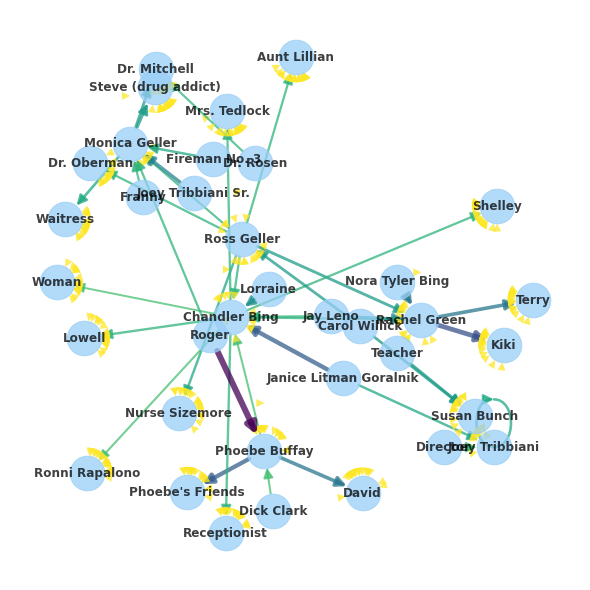

In [ ]:
aff_nw = drawNetwork(aff_df,'Affinity Network')

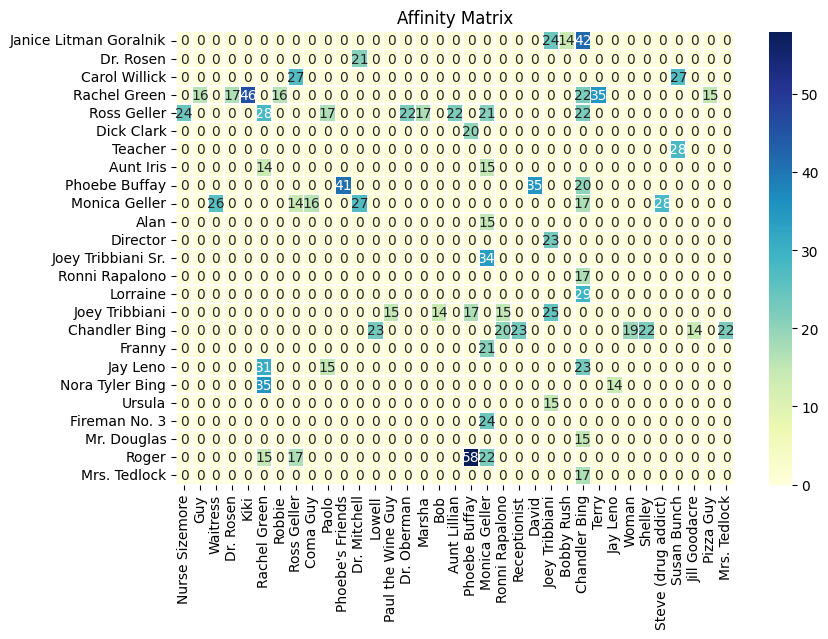

In [ ]:
# Y ya que estamos podemos graficar la matriz
f, ax = plt.subplots(figsize=(9, 6), dpi=100)
seaborn.heatmap(aff_df, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
plt.title('Affinity Matrix')
plt.show()

# Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [ ]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [ ]:
dfs = []

In [ ]:
for file in os.listdir(f"{data_path}/trump_tweets"):
    dfs.append(pd.read_json(f"{data_path}/trump_tweets/" + file))

In [ ]:
df = pd.concat(dfs)

In [ ]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for Android,550441250965708800,"""@ronmeier123: @Macys Your APPAREL is UNPARALL...",2014-12-31 23:59:55+00:00,8,NaN,21,False
1,Twitter for Android,550441111513493504,"""@gillule4: @realDonaldTrump incredible experi...",2014-12-31 23:59:22+00:00,5,NaN,18,False
2,Twitter for Android,550440752254562304,"""@JobSnarechs: Negotiation tip #1: The worst t...",2014-12-31 23:57:56+00:00,33,NaN,44,False
3,Twitter for Android,550440620792492032,"""@joelmch2os: @realDonaldTrump announce your p...",2014-12-31 23:57:25+00:00,8,NaN,26,False
4,Twitter for Android,550440523094577152,"""@djspookyshadow: Feeling a deep gratitude for...",2014-12-31 23:57:02+00:00,9,NaN,31,False


In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [ ]:
train_text.head()

4059    My nomination would increase voter turnout. #V...
4001    "@RickysPlace1: @realDonaldTrump @dxkelley @BO...
190     Prior to the election it was well known that I...
1509    "@patrioticpepe: @realDonaldTrump ONLY TRUMP C...
3500    Look what the President of NBC sent me recentl...
Name: text, dtype: object

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [ ]:
address = "/content/drive/MyDrive/SOCI Computational Content Analysis/data/GloWbe"

In [ ]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [ ]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

text_us_blog_jfy.zip


In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

text_gb_blog_akq.zip


We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

"< h > Look how men 's and women 's magazines write about money < p > I read Oprah 's magazine once in a while Yes I said it And my jaw drops when I see an article like the recent 25 things you do n't have to worry about What Why do I need a magazine to tell me what I do n't need to worry about < p > But I 'm not the target audience It turns out men and women 's magazines are very different in the way they present money Whether that 's good or bad is the subject of a guest post by Nina Smith from Queercents I love how she 's used excerpts to point out the differences in how men 's and women 's magazines write about money < p > -Ramit < p > < p > Investment advice comes in all shapes and sizes Grab a few back issues of Esquire and a quick scan of its investing columns reveals investing advice For example they give the Baby Bells vs Cable Companies < p > So here 's my Aha moment why do men get investing advice in their magazines and we get financial basics in ours < p > Women get touchy 

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

(WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE)


### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal. I trained all of these models using the Googlr Colab file, and then saved the models to disk.

#### Trump GPT-2

In [ ]:
!wget https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-8/run_language_modeling_gpt.py

In [ ]:
# You might have issues with the memory of your GPU in the following code.
# The default Google Colab GPU should work with batch size of 2,
# but if you get a "CUDA out of memory" error, you can reduce it to 1.

# !python run_language_modeling_gpt.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
!python run_language_modeling_gpt.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
# !python run_language_modeling_gpt.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

# If the GPU memory error still occurs even with a batch size of 1,
# you might need to run the code on RCC Midway
# (See https://github.com/UChicago-Computational-Content-Analysis/Frequently-Asked-Questions/issues/18)

In [ ]:
!wget https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-8/run_language_modeling_roberta.py

#### RoBERTa US

In [ ]:
!python run_language_modeling_roberta.py --per_gpu_train_batch_size=1 --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

#### RoBERTa UK

In [ ]:
!python run_language_modeling_roberta.py --output_dir=output_roberta_gb --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

(If you left to use a GPU machine, COME BACK TO THIS NOTEBOOK to load and work with your trained model.)

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_trump_gpt

  File "run_generation.py", line 7
    <!DOCTYPE html>
    ^
SyntaxError: invalid syntax


In [ ]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_trump_gpt")
model_trump = AutoModelWithLMHead.from_pretrained("output_trump_gpt")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [ ]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Obama is going to be a very good president," said Sen. John McCain (R-Ariz.). "He's going to be a very good president. He's going to be a very good president. He's going to be a very good


Quite the contrast.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

GTP fine-tuned with the news dataset seems to arrive to a more accurate predictions than the untrained model.

In [ ]:
news_df = pd.read_excel('/content/drive/MyDrive/SOCI Computational Content Analysis/data/Final Project NOW/NOW corpora final project_cleaned.xlsx') 

In [ ]:
news_df = news_df[:200]

In [ ]:
news_df

In [ ]:
train_text, test_text = train_test_split(news_df['body'], test_size=0.2)

In [ ]:
train_text.to_frame().to_csv(r'train_news', header=None, index=None, sep=' ', mode='a')
test_text.to_frame().to_csv(r'test_news', header=None, index=None, sep=' ', mode='a')

first with GPT-2 (trained with news dataset)

In [ ]:
!python run_language_modeling_gpt.py --per_gpu_train_batch_size=1 --output_dir=output_news_gpt --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_news --do_eval --eval_data_file=test_news

03/09/2022 02:03:49 - WARNING - __main__ -   Process rank: -1, device: cpu, n_gpu: 0, distributed training: False, 16-bits training: False
03/09/2022 02:03:54 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cpu'), do_eval=True, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file='test_news', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=0, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='output_news_gpt', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=1, per_gpu_train_batch_size=1, save_steps=50, save_total_limit=None, seed=42, server_ip='', server_port='', tokenizer_name='', train_data_file='t

In [ ]:
!!wget https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-8/run_generation.py

In [ ]:
!python run_generation.py --model_type=gpt2 --model_name_or_path=output_news

python3: can't open file 'run_generation.py': [Errno 2] No such file or directory


In [ ]:
tokenizer_news = AutoTokenizer.from_pretrained("output_news_gpt")
model_news = AutoModelWithLMHead.from_pretrained("output_news_gpt")


In [ ]:
sequence = "Facebook is guilty of"

input = tokenizer_news.encode(sequence, return_tensors="pt")
generated = model_news.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_news.decode(generated.tolist()[0])
print(resulting_string)

Facebook is guilty of a number of offences including fraud and breach of trust, and has been ordered to pay £1m to the victims. The company has also been ordered to pay £1m to the victims of a cyber attack on the company.


In [ ]:
sequence = "The future of technology will be"

input = tokenizer_news.encode(sequence, return_tensors="pt")
generated = model_news.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_news.decode(generated.tolist()[0])
print(resulting_string)

With GPT-2 pre-trained

In [ ]:
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
sequence = "The future of technology will be"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The future of technology will be determined by the future of the human race.

The future of technology will be determined by the future of the human race.

The future of technology will be determined by the future of the human race.



In [ ]:
sequence = "Facebook is guilty of"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Facebook is guilty of a crime.

The court heard that the defendant, who was a member of the public, was a member of the public at the time of the incident.

The court heard that the defendant was a member of the


In [ ]:
sequence = "Social media platforms led us to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Social media platforms led us to the conclusion that the most effective way to reach out to the public is to use social media to reach out to the people who are most likely to be affected by the crisis.

The most effective way to reach out


---
# Contextual Models 
Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [ ]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer 

In [ ]:
#roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us)
gpt_model_embedding = AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
#roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')
gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [ ]:
text = "Do you have your chips with fish or with salsa?" 

In [ ]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [ ]:
import seaborn as sns

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
def word_vector(text, word_id, model, tokenizer):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    word_embeddings = model(tokens_tensor)[0]
    sentence_embeddings = model(tokens_tensor)[1]
    vector = word_embeddings[0][word_id].detach().numpy()
    return vector

In [ ]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

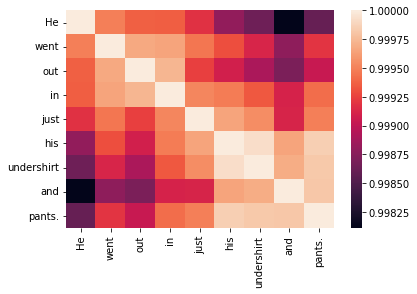

In [ ]:
visualise_diffs(text1, gpt_model_embedding, gpt_tokenizer)

In [ ]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

In [ ]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

## <font color="red">*Exercise 4*</font>

<font color="red">What's a research question relevant to your final project that would benefit from a generative or conversational model like GPT-2 or GPT-3? What task would you have it perform, and how would you evaluate the ouput?
    
<font color="red">_Stretch:_ Do it!

One of the questions that I could look for answer with a conversational model could be (my dataset does not have comments though, but it could have been cool)
1) how does the framing of the news article influence each article's comments?
2) Does the sentiment that the article portrays regarding a particular platform / technology influence the sentiment of the continent?

I wondered if the generative models could help generate hyphotheses for testing. Is that a common practice, or are you being endogenous?*

# Optional: AI Dungeon
A fun way to explore the power of conversation and text generation is [AI Dungeon](https://play.aidungeon.io/main/newGame). If you select _Quick Start_, you can start a text adventure similar to the popular role-playing game Dungeons and Dragons, or the "choose your own adventure" books some of us boomers read as kids. AI Dungeon used to use GPT-2 but now uses GPT-3 to generate text in response to your actions. For example, you may begin with the prompt:

```
You are Jimmy, a wizard living in the kingdom of Larion. You have a staff and a spellbook. You finish your long journey and finally arrive at the ruin you've been looking for. You have come here searching for a mystical spellbook of great power called the book of essence. You look around and see a beautiful woman with raven hair and dark, sparkling eyes. She approaches you and asks you what you seek.

You are now before the one known as Raven.
```

You can respond with any text. I type, `I ask Raven, "What is the meaning of life?"`, to which AI Dungeon says:

```
Raven ponders the question for a moment, and then she answers. Raven says, "It is the pursuit of happiness." What is the pursuit of happiness?
```

I type, `I respond, "Happiness to me would be unearthing the treasures of the Kilarean Empire."`:

```
Raven looks at me and says, "Come with me and live out your one true life."

You go with Raven through many passages and up and down elevators.
```

Raven might be helping me unearth the treasures! Not bad!

There are a lot of tools like AI Dungeon being developed now with state-of-the-art language models. Now that you have some understanding of deep language models, you can better appreciate them—and perhaps design some of your own!